<a href="https://colab.research.google.com/github/eridanletalis/geekbrains_ab/blob/main/hw_ab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Урок 5. Применение математической статистики для проверки гипотез в реальной жизни для популярных метрик </h2>
<div>
Вы провели эксперимент c упрощением формы заказа в магазине Утконос и получили результаты по метрике конверсий в покупку. Выберите метод оценки и оцените есть ли стат.значимые различия между конверсиями в двух группах при alpha = 5%. Дайте краткие рекомендации команде. 
Результаты: 


1.   Число юзеров в группах , которые заходили на сайт в период эксперимента: n1 = 15550 и n2 = 15550.
2.   Число юзеров в группах , которые совершили хотя бы одну покупку за период эксперимента: n1 = 164 и n2 = 228
3.   Конверсии : conv1 = 1.05% conv2 = 1.47%.

</div>

Эксперимент ппроизводился на количественных независимых данных. Предположим, что данные нормально распределены. Для оценки результатов можно использовть разные калькуляторы. Например, описанный здесь Python вариант https://academy.yandex.ru/journal/prostoy-gid-po-bayesovskomu-a-b-testirovaniyu-na-python

In [3]:
from math import lgamma
from numba import jit

#defining the functions used
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [5]:
from scipy.stats import beta
import numpy as np


#This is the known data: impressions and conversions for the Control and Test set
imps_ctrl,convs_ctrl=15550, 164 
imps_test, convs_test=15550, 228

#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, imps_test-convs_test+1
beta_T = beta(a_T, b_T)

#calculating the lift
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

#calculating the probability for Test to be better than Control
prob=calc_prob_between(beta_T, beta_C)

print (f"Test option lift Conversion Rates by {lift*100:2.2f}% with {prob*100:2.1f}% probability.")


Test option lift Conversion Rates by 38.79% with 99.9% probability.


Результат говорит нам  о том, что с вероятность 99,9% конверсия выросла на 38,79%. Это перекрывает 5%-ый альфа (95% уровень значимости), а, значит, ab тест показал, что упрощение формы увеличивает конверсию.

Графический калькулятор показывает те же резульаты
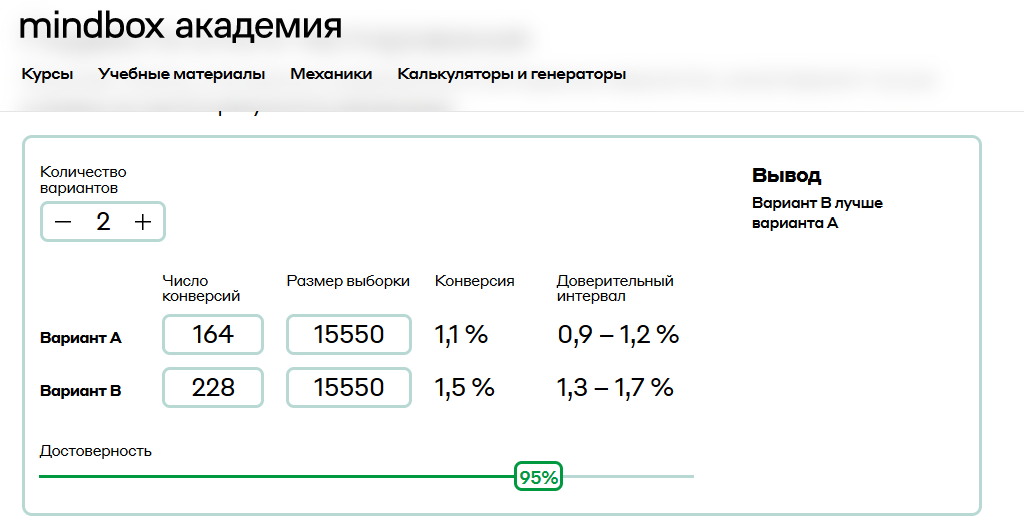

Можем также воспользоваться формулой из примера
$$p _2 - p_1 \pm 1.96 \sqrt{p_1 (1 - p_1) / n_1  + p_2 (1 - p_2) / n_2}$$

Интервал должен захватывать $0$, чтобы нулевая гипотеза была принята

In [8]:
p1 = 1.05 / 100
p2 = 1.47 / 100
n1 = 15550
n2 = 15550

In [10]:
# left
p2 - p1 - 1.96 * ((p1 * (1 - p1) / n1 + p2* (1 - p2) / n2) ** 0.5)

0.0017210902166048432

In [11]:
# right
p2 - p1 + 1.96 * ((p1 * (1 - p1) / n1 + p2* (1 - p2) / n2) ** 0.5)

0.0066789097833951545

Интервал не захватывает $0$, следовательно, для 95% уровня значимости (число $1.96$ используется в t-критерии именно для $\alpha=0.05$) есть статистически значимые отличия

<h3>Сравниваем метрику конверсия в покупку. Размер выборки - 10000 элементов в каждой группе . Какой статистический критерий тут лучше всего подойдёт и почему ?</h3>

Большая выборка говорит в пользу о том, что распределение будет нормальным. Выборки независимы. Значит, лучшим будет критерий Стьюдента для независимых выборок.